In [24]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [25]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# 分類数設定

In [26]:
NUM_CLASSES = 8

# 入力長

In [27]:
TIME_STEPS = 16
DIMENSION = 2

# 学習データ読み込み

In [28]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [29]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [31]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [32]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 24)                792       
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                250       
                                                                 
 dense_5 (Dense)             (None, 8)                 88        
                                                                 
Total params: 1,130
Trainable params: 1,130
Non-trainable params: 0
_________________________________________________________________


In [33]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [34]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [35]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/38 [..............................] - ETA: 8s - loss: 2.0727 - accuracy: 0.0938
Epoch 1: saving model to model/point_history_classifier/point_history_classifier.hdf5
38/38 [==============================] - 0s 4ms/step - loss: 2.0411 - accuracy: 0.3203 - val_loss: 1.9941 - val_accuracy: 0.3591
Epoch 2/1000
 1/38 [..............................] - ETA: 0s - loss: 1.9933 - accuracy: 0.2969
Epoch 2: saving model to model/point_history_classifier/point_history_classifier.hdf5
38/38 [==============================] - 0s 2ms/step - loss: 1.9634 - accuracy: 0.3384 - val_loss: 1.9064 - val_accuracy: 0.3609
Epoch 3/1000
 1/38 [..............................] - ETA: 0s - loss: 1.8771 - accuracy: 0.3672
Epoch 3: saving model to model/point_history_classifier/point_history_classifier.hdf5
38/38 [==============================] - 0s 2ms/step - loss: 1.8858 - accuracy: 0.3452 - val_loss: 1.8171 - val_accuracy: 0.3684
Epoch 4/1000
 1/38 [..............................] - ETA: 0s - los

In [36]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [37]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[0.92528063 0.01169738 0.00698596 0.0123054  0.00613794 0.01890335
 0.01031771 0.0083717 ]
0


# 混同行列

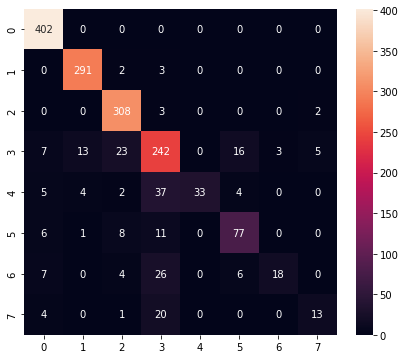

Classification Report
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       402
           1       0.94      0.98      0.96       296
           2       0.89      0.98      0.93       313
           3       0.71      0.78      0.74       309
           4       1.00      0.39      0.56        85
           5       0.75      0.75      0.75       103
           6       0.86      0.30      0.44        61
           7       0.65      0.34      0.45        38

    accuracy                           0.86      1607
   macro avg       0.84      0.69      0.72      1607
weighted avg       0.86      0.86      0.85      1607



In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [39]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [40]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [41]:
# モデルを変換(量子化
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/km/k1t_66r11l9b1dgwdbhqdh880000gn/T/tmp9uftjq87/assets


INFO:tensorflow:Assets written to: /var/folders/km/k1t_66r11l9b1dgwdbhqdh880000gn/T/tmp9uftjq87/assets
2022-03-23 13:22:30.148899: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-03-23 13:22:30.148913: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-03-23 13:22:30.149021: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/km/k1t_66r11l9b1dgwdbhqdh880000gn/T/tmp9uftjq87
2022-03-23 13:22:30.150251: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-03-23 13:22:30.150263: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/km/k1t_66r11l9b1dgwdbhqdh880000gn/T/tmp9uftjq87
2022-03-23 13:22:30.154308: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-03-23 13:22:30.171208: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

6496

# 推論テスト

In [42]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [43]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 32], dtype=int32), 'shape_signature': array([-1, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [44]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [45]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 32 µs, sys: 7 µs, total: 39 µs
Wall time: 46 µs


In [46]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.92528063 0.01169737 0.00698596 0.0123054  0.00613794 0.01890335
 0.01031771 0.0083717 ]
0
